# Generate features

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import skew, kurtosis

In [2]:
# Custom function to retrieve the local raw data
def get_rawdata (symbol = 'EQ/SPX', path_ip = 'Financial Data/CSV Data/'):
    
    file_ip = path_ip+symbol+'.csv'
    data = pd.read_csv(file_ip, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    data = data['2006':]
    
    return data

## Raw Features Distribution

In [3]:
# Test each individual feature using C1 as sample data
data = get_rawdata ('EQ/FTSEMIB')
data.head()

,O,H,L,C,V,OI
2006-01-02,35756.0,35999.0,35741.0,35962.0,168169000.0,0.0
2006-01-03,36043.0,36259.0,35975.0,36093.0,466935000.0,0.0
2006-01-04,36337.0,36371.0,36205.0,36336.0,547137000.0,0.0
2006-01-05,36387.0,36387.0,36080.0,36085.0,602757000.0,0.0
2006-01-06,36121.0,36365.0,36046.0,36365.0,292966000.0,0.0


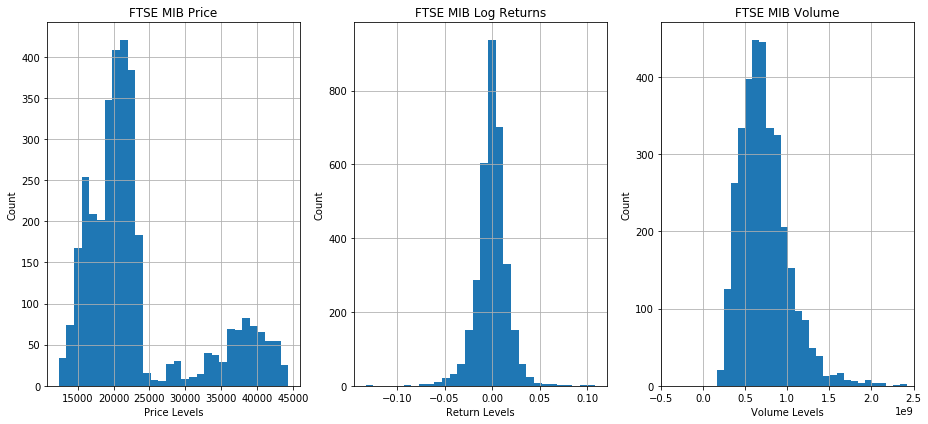

In [4]:
fig, axs = plt.subplots(1,3) # plot 3 by 2

axs[0].hist(data['C'], bins=30)
axs[0].set_title('FTSE MIB Price')
axs[0].set_xlabel('Price Levels')
axs[0].set_ylabel('Count')
axs[0].grid()

axs[1].hist(np.log(data['C']).diff(1).dropna(), bins=30)
axs[1].set_title('FTSE MIB Log Returns')
axs[1].set_xlabel('Return Levels')
axs[1].set_ylabel('Count')
axs[1].grid()

axs[2].hist(data['V'], bins=30)
axs[2].set_title('FTSE MIB Volume')
axs[2].set_xlabel('Volume Levels')
axs[2].set_ylabel('Count')
axs[2].set_xlim((-5e8, 2.5e9))
axs[2].grid()

fig.set_size_inches(13,6)
fig.tight_layout()

## Individual Features 

philipperemy/fractional-differentiation-time-series

In [5]:
def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])


def get_weights(d, size):
    # thres>0 drops insignificant weights
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def fracDiff_original_impl(series, d, thres=.01):
    # 1) Compute weights for the longest series
    w = get_weights(d, series.shape[0])
    # 2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    # 3) Apply weights to values
    # df = {}
    output = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]): continue  # exclude NAs
            output[loc] = np.dot(w[-(iloc + 1):, :].T, seriesF.loc[:loc])[0, 0]
        # df[name] = df_.copy(deep=True)
    # df = pd.concat(df, axis=1)
    return output


def get_weight_ffd(d, thres, lim):
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def fracDiff_FFD_original_impl(series, d, thres=1e-5):
    import pandas as pd
    # 1) Compute weights for the longest series
    w = get_weight_ffd(d, thres, len(series))
    width = len(w) - 1
    # df = {}
    output = []
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        output.extend([0] * width)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue  # exclude NAs
            # df_[loc1] =
            output.append(np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0])
        # df[name] = df_.copy(deep=True)
    # df = pd.concat(df, axis=1)
    return output


def frac_diff_ffd(x, d, thres=1e-5):
    w = get_weight_ffd(d, thres, len(x))
    width = len(w) - 1
    output = []
    output.extend([0] * width)
    for i in range(width, len(x)):
        output.append(np.dot(w.T, x[i - width:i + 1])[0])
    return np.array(output)


In [6]:
# Test each individual feature using SPX as sample data
data = get_rawdata ()
data.head()

,O,H,L,C,V,OI
2006-01-03,1248.29,1270.22,1245.74,1268.80,1.512000e+09,0.0
2006-01-04,1268.80,1275.37,1267.74,1273.46,1.451000e+09,0.0
2006-01-05,1273.46,1276.91,1270.30,1273.48,1.420000e+09,0.0
2006-01-06,1273.48,1286.09,1273.48,1285.45,1.537000e+09,0.0
2006-01-09,1285.45,1290.78,1284.82,1290.15,1.318000e+09,0.0


In [7]:
# def FD_sig (close):
#     fracs = frac_diff_ffd(np.log(close), d=0.5, thres=5e-3)
#     sig = pd.Series(index=close.index)
#     sig[20:] = fracs[20:]
#     return sig

# sig = FD_sig (data['C'])

# fig, axs = plt.subplots(1,1) 
# axs.plot(sig)
# axs.twinx().plot(data['C'], color='r')

# plt.figure()
# plt.hist(sig.dropna())

In [8]:
#%% log return
def LR_sig (array):

    sig = np.log(array).diff(1)
    
    return sig

# array = data['C']
# sig = LR_sig(array)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# plt.figure()
# plt.plot(sig.cumsum())
# print(sig.head())
# print(sig.tail())

# logr=sig

In [9]:
# moving return average
def rMA_sig (array, w):
    sig = array.rolling(w).mean()
    return sig

# array = logr
# sig = rMA_sig(array, 5)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [10]:
# moving return STD
def rMSTD_sig (array, w):
    sig = array.rolling(w).std()
    return sig

# array = logr
# sig = rMSTD_sig(array, 5)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [11]:
# moving return skew
def rMS_sig (array, w):
    sig = array.rolling(w).apply(skew, raw=True)
    return sig

# array = logr
# sig = rMS_sig(array, 5)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [12]:
# moving return kurtosis
def rMK_sig (array, w):
    sig = array.rolling(w).apply(kurtosis, raw=True)
    return sig

# array = logr
# sig = rMK_sig(array, 5)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [13]:
# Relative H/L closing
def RHLC_sig (h, l, c):

    sig = (c-l)/(h-l)
    sig = sig.clip(0, 1)
    sig = sig.fillna(0.5) # assume exactly in the middle otherwise (h==l==c)
    
    return sig

# h = data['H']
# l = data['L']
# c = data['C']
# sig = RHLC_sig(h,l,c)

# plt.figure()
# plt.plot(h)
# plt.plot(l)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [14]:
# Relative min-max position
def RMM_sig (array, w):

    mins = array.rolling(w).min()
    maxs = array.rolling(w).max()
    sig = (array-mins)/(maxs-mins)

    return sig

# array = data['C']
# sig = RMM_sig(array, 10)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [15]:
# H/L Spread
def HLS_sig (h, l):

    sig = abs((h-l)/l)
    sig = sig.replace([np.inf, -np.inf], np.nan)
    sig = sig.fillna(0)
    
    return sig

# h = data['H']
# l = data['L']
# sig = HLS_sig(h,l)

# plt.figure()
# plt.plot(h)
# plt.plot(l)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

In [16]:
# #%% Hours signal
# def WeekDay_sig (array):

#     wds = array.index.weekday.values
#     sig = pd.Series(index=array.index, data=wds)
    
#     return sig

# array = data['C']
# sig = WeekDay_sig(array)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head(10))
# print(sig.tail())

In [17]:
# # Price moving average cross-overs
# def MAX_sig (array, ws, wl):

#     mas = array.rolling(ws).mean()
#     mal = array.rolling(wl).mean()
#     sig = (mas - mal)/mas

#     return sig

# array = data['C']
# sig = MAX_sig(array, 5, 15)

# plt.figure()
# plt.plot(array)
# plt.figure()
# plt.plot(sig)
# print(sig.head())
# print(sig.tail())

## Features Generation 

In [18]:
path_op = 'Financial Data/Features4/'

In [19]:
symbols = ['EQ/SPX','EQ/MXCA','EQ/UKX','EQ/FTSEMIB','EQ/SHSZ300','EQ/NKY']
for symbol in symbols:

    data = get_rawdata (symbol)
    features = pd.DataFrame()

    # prices features
    logr = LR_sig(data['C'])
    features['r'] = logr
    features['RHLC'] = RHLC_sig(data['H'],data['L'],data['C'])
    features['HLS'] = HLS_sig (data['H'],data['L'])
    for w in (5, 10, 22):
        features['rMA'+str(w)] = rMA_sig(logr, w)
        features['rMSTD'+str(w)] = rMSTD_sig(logr, w)
        features['rMS'+str(w)] = rMS_sig(logr, w)
        features['rMK'+str(w)] = rMK_sig(logr, w)
        features['RMM'+str(w)] = RMM_sig(data['C'], w)

    # volume features
    features['V'] = data['V']

    # open interest features
    features['OI'] = data['OI']
    
    features.to_csv(path_op+symbol+'.csv')
    
    print(symbol)
    print(features.shape)
    print(features.dropna().shape)

EQ/SPX
(3372, 20)
(3350, 20)
EQ/MXCA
(3365, 20)
(3343, 20)
EQ/UKX
(3386, 20)
(3364, 20)
EQ/FTSEMIB
(3400, 20)
(3378, 20)
EQ/SHSZ300
(3257, 20)
(3235, 20)
EQ/NKY
(3284, 20)
(3262, 20)


In [20]:
symbols = ['FX/CHFUSD','FX/CADUSD','FX/GBPUSD','FX/EURUSD','FX/CNYUSD','FX/JPYUSD']
for symbol in symbols:

    data = get_rawdata (symbol)
    features = pd.DataFrame()

    # prices features
    logr = LR_sig(data['C'])
    features['r'] = logr
    features['RHLC'] = RHLC_sig(data['H'],data['L'],data['C'])
    features['HLS'] = HLS_sig (data['H'],data['L'])
    for w in (5, 10, 22):
        features['rMA'+str(w)] = rMA_sig(logr, w)
        features['rMSTD'+str(w)] = rMSTD_sig(logr, w)
        features['rMS'+str(w)] = rMS_sig(logr, w)
        features['rMK'+str(w)] = rMK_sig(logr, w)
        features['RMM'+str(w)] = RMM_sig(data['C'], w)

    # volume features
    features['V'] = data['V']

    # open interest features
    features['OI'] = data['OI']
    
    features.to_csv(path_op+symbol+'.csv')
    
    print(symbol)
    print(features.shape)
    print(features.dropna().shape)      

FX/CHFUSD
(3498, 20)
(3476, 20)
FX/CADUSD
(3498, 20)
(3476, 20)
FX/GBPUSD
(3498, 20)
(3476, 20)
FX/EURUSD
(3498, 20)
(3476, 20)
FX/CNYUSD
(3497, 20)
(3464, 20)
FX/JPYUSD
(3498, 20)
(3476, 20)


In [21]:
symbols = ['CO/GC1','CO/HG1','CO/CL1','CO/NG1','CO/S1','CO/C1']
for symbol in symbols:

    data = get_rawdata (symbol)
    features = pd.DataFrame()

    # prices features
    logr = LR_sig(data['C'])
    features['r'] = logr
    features['RHLC'] = RHLC_sig(data['H'],data['L'],data['C'])
    features['HLS'] = HLS_sig (data['H'],data['L'])
    for w in (5, 10, 22):
        features['rMA'+str(w)] = rMA_sig(logr, w)
        features['rMSTD'+str(w)] = rMSTD_sig(logr, w)
        features['rMS'+str(w)] = rMS_sig(logr, w)
        features['rMK'+str(w)] = rMK_sig(logr, w)
        features['RMM'+str(w)] = RMM_sig(data['C'], w)

    # volume features
    features['V'] = data['V']

    # open interest features
    features['OI'] = data['OI']
    
    features.to_csv(path_op+symbol+'.csv')
    
    print(symbol)
    print(features.shape)
    print(features.dropna().shape)      

CO/GC1
(3348, 20)
(3326, 20)
CO/HG1
(3356, 20)
(3334, 20)
CO/CL1
(3343, 20)
(3321, 20)
CO/NG1
(3332, 20)
(3310, 20)
CO/S1
(3349, 20)
(3327, 20)
CO/C1
(3368, 20)
(3346, 20)


In [22]:
symbols = ['FI/USGG10YR','FI/GCAN10YR','FI/GUKG10','FI/GBTPGR10','FI/GCNY10YR','FI/GJGB10']
for symbol in symbols:

    data = get_rawdata (symbol)
    features = pd.DataFrame()

    # prices features
    logr = LR_sig(data['C']+1) # To handle the negative yield in Japan, add a costant to everything
    features['r'] = logr
    features['RHLC'] = RHLC_sig(data['H'],data['L'],data['C'])
    features['HLS'] = HLS_sig (data['H'],data['L'])
    for w in (5, 10, 22):
        features['rMA'+str(w)] = rMA_sig(logr, w)
        features['rMSTD'+str(w)] = rMSTD_sig(logr, w)
        features['rMS'+str(w)] = rMS_sig(logr, w)
        features['rMK'+str(w)] = rMK_sig(logr, w)
        features['RMM'+str(w)] = RMM_sig(data['C'], w)

    # volume features
    features['V'] = data['V']

    # open interest features
    features['OI'] = data['OI']
    
    features.to_csv(path_op+symbol+'.csv')
    
    print(symbol)
    print(features.shape)
    print(features.dropna().shape)      

FI/USGG10YR
(3353, 20)
(3331, 20)
FI/GCAN10YR
(3354, 20)
(3332, 20)
FI/GUKG10
(3387, 20)
(3365, 20)
FI/GBTPGR10
(3425, 20)
(3403, 20)
FI/GCNY10YR
(2986, 20)
(2932, 20)
FI/GJGB10
(3284, 20)
(3262, 20)


In [23]:
print(symbol)
features

FI/GJGB10


,r,RHLC,HLS,rMA5,rMSTD5,rMS5,rMK5,RMM5,rMA10,rMSTD10,rMS10,rMK10,RMM10,rMA22,rMSTD22,rMS22,rMK22,RMM22,V,OI
2006-01-04,NaN,0.000000,0.020690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-05,-0.002043,0.428571,0.024476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-06,0.002043,0.600000,0.017422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-10,-0.006141,0.400000,0.035336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-11,0.010215,0.800000,0.017361,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-12,-0.002442,0.475000,0.027875,0.000326,0.006242,0.766578,-0.650792,0.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-13,0.002035,0.823529,0.011765,0.001142,0.006120,0.385191,-0.826687,0.960000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-16,0.002031,0.760000,0.017301,0.001140,0.006119,0.386511,-0.825435,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-17,-0.011839,0.000000,0.020906,0.000000,0.008043,-0.317783,-0.714317,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2006-01-18,0.003689,0.971429,0.024823,-0.001305,0.006315,-1.078415,-0.408192,0.310345,NaN,NaN,NaN,NaN,0.310345,NaN,NaN,NaN,NaN,NaN,0.0,0.0


## Features Distribution

In [24]:
# Custom function to retrieve the local raw data
def get_features (symbol = 'EQ/SPX', path_ip = 'Financial Data/Features4/'):
    
    file_ip = path_ip+symbol+'.csv'
    data = pd.read_csv(file_ip, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    
    return data

In [25]:
features = get_features('EQ/NKY')

In [26]:
features.columns

Index(['r', 'RHLC', 'HLS', 'rMA5', 'rMSTD5', 'rMS5', 'rMK5', 'RMM5', 'rMA10',
       'rMSTD10', 'rMS10', 'rMK10', 'RMM10', 'rMA22', 'rMSTD22', 'rMS22',
       'rMK22', 'RMM22', 'V', 'OI'],
      dtype='object')

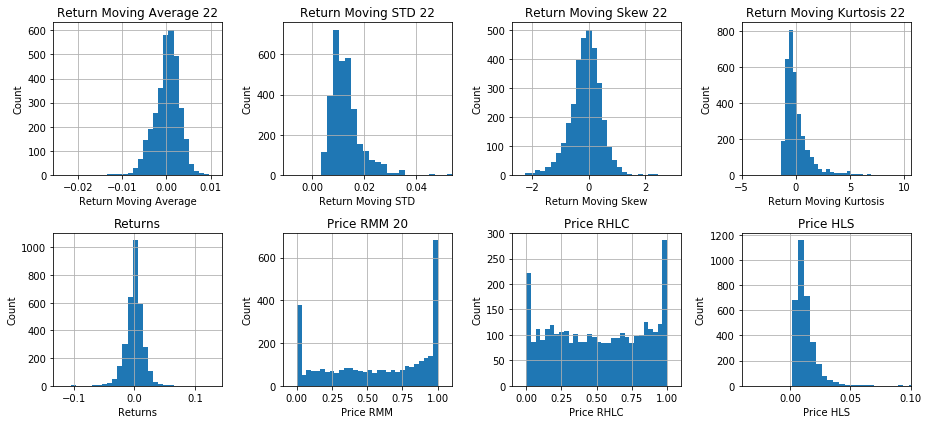

In [27]:
fig, axs = plt.subplots(2,4) # plot 3 by 2

tmp = features['rMA22'].copy().dropna()
axs[0][0].hist(tmp, bins=30)
axs[0][0].set_title('Return Moving Average 22')
axs[0][0].set_xlabel('Return Moving Average')
axs[0][0].set_ylabel('Count')
axs[0][0].grid()

tmp = features['rMSTD22'].copy().dropna()
axs[0][1].hist(tmp, bins=30)
axs[0][1].set_title('Return Moving STD 22')
axs[0][1].set_xlabel('Return Moving STD')
axs[0][1].set_ylabel('Count')
axs[0][1].set_xlim((-0.0113402902595218817, 0.05379216030633729))
axs[0][1].grid()

tmp = features['rMS22'].copy().dropna()
axs[0][2].hist(tmp, bins=30)
axs[0][2].set_title('Return Moving Skew 22')
axs[0][2].set_xlabel('Return Moving Skew')
axs[0][2].set_ylabel('Count')
axs[0][2].grid()

tmp = features['rMK22'].copy().dropna()
axs[0][3].hist(tmp, bins=30)
axs[0][3].set_title('Return Moving Kurtosis 22')
axs[0][3].set_xlabel('Return Moving Kurtosis')
axs[0][3].set_ylabel('Count')
axs[0][3].grid()
axs[0][3].set_xlim((-5, 10.5626183571862))

tmp = features['r'].copy().dropna()
axs[1][0].hist(tmp, bins=30)
axs[1][0].set_title('Returns')
axs[1][0].set_xlabel('Returns')
axs[1][0].set_ylabel('Count')
axs[1][0].grid()

tmp = features['RMM22'].copy().dropna()
axs[1][1].hist(tmp, bins=30)
axs[1][1].set_title('Price RMM 20')
axs[1][1].set_xlabel('Price RMM')
axs[1][1].set_ylabel('Count')
axs[1][1].grid()
axs[1][1].set_xlim((-0.1, 1.1))

tmp = features['RHLC'].copy().dropna()
axs[1][2].hist(tmp, bins=30)
axs[1][2].set_title('Price RHLC')
axs[1][2].set_xlabel('Price RHLC')
axs[1][2].set_ylabel('Count')
axs[1][2].grid()
axs[1][2].set_xlim((-0.1, 1.1))

tmp = features['HLS'].copy().dropna()
axs[1][3].hist(tmp, bins=30)
axs[1][3].set_title('Price HLS')
axs[1][3].set_xlabel('Price HLS')
axs[1][3].set_ylabel('Count')
axs[1][3].grid()
axs[1][3].set_xlim((-0.04, 0.1))

fig.set_size_inches(13,6)
fig.tight_layout()

## Uniform Time

Need to format all csv files such that the time range is the same for every matrix

In [28]:
# Custom function to retrieve the local raw data
def get_features (symbol = 'EQ/SPX', path_ip = 'Financial Data/Features4/'):
    
    file_ip = path_ip+symbol+'.csv'
    data = pd.read_csv(file_ip, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    
    return data

In [29]:
# All available symbols
symbols = ['EQ/SPX','EQ/MXCA','EQ/UKX','EQ/FTSEMIB','EQ/SHSZ300','EQ/NKY',
          'FX/CHFUSD','FX/CADUSD','FX/GBPUSD','FX/EURUSD','FX/CNYUSD','FX/JPYUSD',
          'CO/GC1','CO/HG1','CO/CL1','CO/NG1','CO/S1','CO/C1',
          'FI/USGG10YR','FI/GCAN10YR','FI/GUKG10','FI/GBTPGR10','FI/GCNY10YR','FI/GJGB10']

In [30]:
# Find the indices in common with all datasets 
idxs = None
for symbol in symbols:
    
    if idxs == None:
        idxs = set(get_features(symbol).dropna().index)
    else:
        idxs = idxs.intersection(set(get_features(symbol).dropna().index))
        
idxs_min = min(idxs)
idxs_max = max(idxs)

print(len(idxs))
print(idxs_min, idxs_max)

2484
2006-05-10 00:00:00 2019-05-28 00:00:00


In [31]:
# Produce the labels with the same indices
labels = pd.DataFrame()
for symbol in symbols:
    
    if 'FI' in symbol:
        print(symbol)
        label = np.log(get_rawdata(symbol)['C']+1).diff(1).shift(-1)
    else:
        label = np.log(get_rawdata(symbol)['C']).diff(1).shift(-1)
    label = label[idxs_min:idxs_max]
    labels[symbol[3:]] = label

labels = labels.sort_index()
labels = labels.fillna(0)
labels.to_csv('Financial Data/Features4/labels4.csv')

idxs = labels.index

print(labels.shape)
labels.head()

FI/USGG10YR
FI/GCAN10YR
FI/GUKG10
FI/GBTPGR10
FI/GCNY10YR
FI/GJGB10
(3284, 24)


,SPX,MXCA,UKX,FTSEMIB,SHSZ300,NKY,CHFUSD,CADUSD,GBPUSD,EURUSD,...,CL1,NG1,S1,C1,USGG10YR,GCAN10YR,GUKG10,GBTPGR10,GCNY10YR,GJGB10
2006-05-10,-0.012881,-0.013551,-0.006829,-0.003084,-0.008640,-0.005311,0.004013,-0.002534,0.010036,0.004216,...,0.016363,-0.037055,0.015887,0.033140,0.004497,-0.001646,0.007353,0.015748,-0.006781,-0.009041
2006-05-11,-0.011305,-0.010470,-0.021734,-0.015276,0.032316,-0.015561,0.013141,-0.006085,0.006354,0.007142,...,-0.017612,-0.057096,-0.004573,0.043217,0.006934,-0.000732,0.001917,0.003157,0.006781,0.007039
2006-05-12,0.002522,-0.014732,-0.012048,-0.012386,0.042220,-0.006943,-0.011807,-0.002890,-0.008055,-0.010185,...,-0.037191,-0.025318,0.007472,0.046245,-0.006560,-0.007908,-0.011205,-0.011751,-0.004516,0.004998
2006-05-15,-0.001871,-0.001390,0.000839,0.001813,-0.015675,-0.020125,0.004233,0.005549,0.004513,0.004833,...,0.001727,0.020849,-0.002899,-0.003854,-0.009569,-0.008343,-0.011154,-0.007533,0.001256,-0.013383
2006-05-16,-0.016984,-0.016222,-0.029633,-0.028890,0.003293,0.009194,-0.006538,-0.006440,-0.002705,-0.009062,...,-0.012155,-0.019870,0.002072,0.015326,0.007910,0.002232,0.009568,0.014078,0.001255,-0.014931


In [32]:
# reindex the features 
path_op = 'Financial Data/Features4/'
for symbol in symbols:
    
    print(symbol)
    features = get_features(symbol)
    print(features.shape)
    features = features.reindex(idxs)
    print(features.shape)
    features = features.sort_index()
    features = features.fillna(features.mean())
    features.to_csv(path_op+symbol+'.csv')    

EQ/SPX
(3372, 20)
(3284, 20)
EQ/MXCA
(3365, 20)
(3284, 20)
EQ/UKX
(3386, 20)
(3284, 20)
EQ/FTSEMIB
(3400, 20)
(3284, 20)
EQ/SHSZ300
(3257, 20)
(3284, 20)
EQ/NKY
(3284, 20)
(3284, 20)
FX/CHFUSD
(3498, 20)
(3284, 20)
FX/CADUSD
(3498, 20)
(3284, 20)
FX/GBPUSD
(3498, 20)
(3284, 20)
FX/EURUSD
(3498, 20)
(3284, 20)
FX/CNYUSD
(3497, 20)
(3284, 20)
FX/JPYUSD
(3498, 20)
(3284, 20)
CO/GC1
(3348, 20)
(3284, 20)
CO/HG1
(3356, 20)
(3284, 20)
CO/CL1
(3343, 20)
(3284, 20)
CO/NG1
(3332, 20)
(3284, 20)
CO/S1
(3349, 20)
(3284, 20)
CO/C1
(3368, 20)
(3284, 20)
FI/USGG10YR
(3353, 20)
(3284, 20)
FI/GCAN10YR
(3354, 20)
(3284, 20)
FI/GUKG10
(3387, 20)
(3284, 20)
FI/GBTPGR10
(3425, 20)
(3284, 20)
FI/GCNY10YR
(2986, 20)
(3284, 20)
FI/GJGB10
(3284, 20)
(3284, 20)
